# Лекция 6

## Расчет мощности теста
вероятность верно отлонить нулевую гипотезу, при условии наличия эффекта

In [ ]:
# Импорт библиотек
import math as m
import pandas as pd
import numpy as np
from numpy import array

# библиотеки статистических функций
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.power import NormalIndPower

# графические библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,6)

**1. Расчет мощности для t- и z-тестов, используя библиотеку statsmodels**

<br>Потребуется задать:
* величину стандартизированного эффекта (индекс Коэна), т.е. разницу между средними, делённую на стандартное отклонение
* размер имеющейся выборки
* уровень значимости

In [ ]:
# исходные данные
mean_control = 1                               # ср. значение в контрольной группе
mean_treatment = 1.1                           # ср. значение в тестовой группе с учетом прироста
delta = abs(mean_treatment - mean_control)     # ожидаемый менеджером прирост
sd_mean_control = 1                            # стандартное отклонение в контрольной группе
sd_mean_treatment = 1                          # стандартное отклонение в тестовой группе

# расчет стандартизированного эффекта (индекса Коэна) для разницы средних
effect_size_calc = delta / ((sd_mean_control  + sd_mean_treatment) / 2)
print('Стандартизированная величина эффекта:', round(effect_size_calc, 3))
# расчет стандартизированного эффекта (индекса Коэна) для разницы долей

Стандартизированная величина эффекта: 0.1


In [ ]:
# функция мощности t-test
effect_size = round(effect_size_calc,3) # размер стандартизированного эффекта
sample_size = 200 # размер имеющейся выборки
alpha = 0.05 # установленный уровень значимости

# Функция мощности t-теста
ttest_power = TTestIndPower()

t_test_power = (
    ttest_power.power(
                effect_size = effect_size,
                nobs1 = sample_size,
                alpha = alpha)
             )

print(f"Вероятность, что тест зафиксирует эффект в {effect_size} \
(мощность):", "{:.1%}".format(t_test_power))

Вероятность, что тест зафиксирует эффект в 0.1 (мощность): 16.9%


In [ ]:
# Функция мощности z-теста
ztest_power = NormalIndPower()
sample_size = 200
alpha = 0.3

z_test_power = (
    ztest_power.solve_power(
                effect_size = effect_size,
                nobs1 = sample_size,
                alpha = alpha)
             )
print(f"Вероятность, что тест зафиксирует эффект в {effect_size} \
(мощность):", "{:.1%}".format(z_test_power))

Вероятность, что тест зафиксирует эффект в 0.1 (мощность): 50.6%


## 2. MDE, размер эффекта

In [ ]:
MDE_std = tt_ind_solve_power(effect_size = None,
                       alpha = 0.05,
                       power = 0.8,
                       ratio = 1,
                       alternative = "two-sided",
                      nobs1 = 200)
print('Стандартизированный MDE, который мы можем себе позволить на заданном дизайне эксперимента =', MDE_std)
print('Абсолютный MDE, который мы можем себе позволить на заданном дизайне эксперимента =', MDE_std * sd_mean_control)

Стандартизированный MDE, который мы можем себе позволить на заданном дизайне эксперимента = 0.28083522542893885
Абсолютный MDE, который мы можем себе позволить на заданном дизайне эксперимента = 0.28083522542893885


In [ ]:
sample_size = tt_ind_solve_power(effect_size = MDE_std,
                       alpha = 0.05,
                       power = 0.8,
                       ratio = 1,
                       alternative = "two-sided",
                       nobs1 = None)
print('Размер выборки под заданный MDE = ', round(sample_size))

Размер выборки под заданный MDE =  200


## 2. Расчет мощности теста, исходя из имеющегося размера выборки, используя симуляции

In [ ]:
rel_delta = 0.1               # относительный размер эффекта
control_mean = 1              # ср. в контрольной группе
control_sd = 1                # ст. отклонение в контрольной группе
sample_size = 200     # размер выборки из предыдущего расчета
alpha = 0.05                  # уровень значимости
n_sim = 10000                 # количество повторных симуляций
np.random.seed(123)

In [ ]:
# сгенерируем нормальные данные n_sim раз (множество пар выборок)
def simulate_data(control_mean, control_sd, rel_delta, sample_size, n_sim):

    # Генерация значений для нулевой гипотезы из нормального распределения с заданными параметрами
    control = np.random.normal(loc = control_mean,
                               scale = control_sd,
                               size = (round(sample_size), n_sim))

    # Генерация значений для альтернативной гипотезы из нормального распределения с заданными параметрами
    treatment = np.random.normal(loc = control_mean*(1 + rel_delta),
                                 scale = control_sd,
                                 size = (round(sample_size), n_sim))

    return control, treatment

In [ ]:
# Проведение t-теста
control, treatment = simulate_data(control_mean,
                                   control_sd,
                                   rel_delta,
                                   sample_size,
                                   n_sim)
t_stat_list, p_value_list = ss.ttest_ind(control, treatment)
p_value_list[0:10]

array([0.25385589, 0.00722783, 0.15487025, 0.79669612, 0.06203134,
       0.17896585, 0.31998567, 0.14144515, 0.06411049, 0.60622882])

<AxesSubplot:ylabel='Density'>

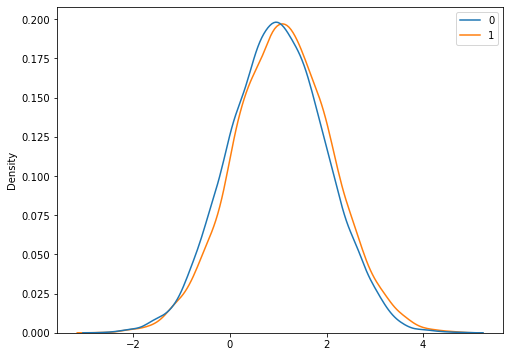

In [ ]:
# Пример распределений для 2-х гипотез в одной из симуляций
sns.kdeplot(data=[control[100], treatment[100]])

In [ ]:
power = (p_value_list < 0.05).sum() / n_sim
print("Мощность эксперимента: {:.1%}".format(power))

Мощность эксперимента: 17.2%


## 3. Анализ мощности

**Рекомендации на литературу по расчету выборки:** </br>
Douglas Altman. Statistics with Confidence: Confidence Intervals and Statistical Guidelines </br>
https://www.amazon.com/Statistics-Confidence-Intervals-Statistical-Guidelines/dp/0727913751
    
Jerrold Zar. Biostatistical Analysis </br>
https://www.amazon.com/Biostatistical-Analysis-Books-Carte-5th/dp/0321656865

David Machin. Sample Sizes for Clinical, Laboratory and Epidemiology Studies </br>
https://www.amazon.com/Sample-Clinical-Laboratory-Epidemiology-Studies-dp-1118874943/dp/1118874943/ref=dp_ob_title_bk

Charles DiMaggio. Power Tools for Epidemiologists </br>
http://www.columbia.edu/~cjd11/charles_dimaggio/DIRE/styled-4/code-12/

Evan Miller. How Not To Run an A/B Test </br>
https://www.evanmiller.org/how-not-to-run-an-ab-test.html

The World Bank. Power Calculations </br>
https://dimewiki.worldbank.org/Power_Calculations

Sample size, power and effect size revisited (обзорная статья, приведены рекомендации по расчету) </br>
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7745163/#r16


**Рекомендации онлайн калькуляторов и программ:** </br>
Python: statsmodels.stats.power </br>
https://www.statsmodels.org/stable/stats.html#power-and-sample-size-calculations

R: pwr package</br>
https://cran.r-project.org/web/packages/pwr/vignettes/pwr-vignette.html

калькулятор Evanmiller</br>
https://www.evanmiller.org/ab-testing/sample-size.html

калькулятор Mindbox</br>
https://mindbox.ru/academy/ab-test-calculator/

ПО PASS (детальная документация)</br>
https://www.ncss.com/

## Расчет размера выборки для достижения требуемой мощности

**1. Расчет размера выборки, используя аналитический метод**

In [ ]:
rel_effect = 0.1         # минимальный аплифт, который ожидает менеджер
control_mean = 1         # среднее в контрольной группе
control_sd = 1           # стандартное отклонение в контрольной группе
alpha = 0.05             # уровень значимости

In [ ]:
from statsmodels.stats.power import tt_ind_solve_power

treat_mean = control_mean*(1 + rel_effect)
mean_diff = treat_mean - control_mean

# Расчет индекса Коэна
cohen_d = mean_diff / control_sd

n = tt_ind_solve_power(effect_size = cohen_d,
                       alpha = alpha,
                       power = 0.8,
                       ratio = 1,
                       alternative = "two-sided")
print('Минимальный размер выборки для достижения уровня значимости: {:.0f}'.format(round(n)))

Минимальный размер выборки для достижения уровня значимости: 1571


In [ ]:
# Расчет размера выборки используя приближенную формулу
sample_size = 15.7 * control_sd**2 / delta**2
print('Минимальный размер выборки: {:.0f}'.format(round(sample_size)))

Минимальный размер выборки: 1570


**2. Расчет размера выборки, используя симуляции**

Text(1454, 0.05, 'Размер выборки через симуляцию ~ 1530')

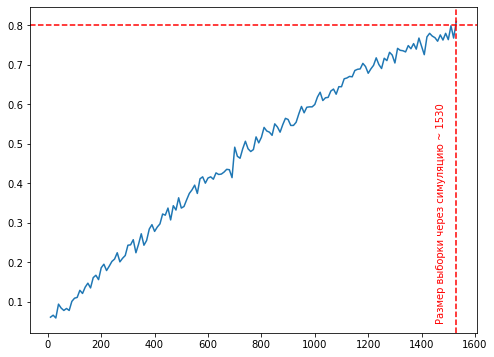

In [ ]:
sample_size_start = 10         # начальный размер выборки для симуляции
power_set = 0.8                # требуемый уровень мощности теста
alpha = 0.05                   # уровень значимости
control_mean = 1               # среднее в контрольной группе
control_sd = 1                 # стандартное отклонение в контрольной группе
n_sim = 1000                   # количество повторных симуляций
rel_delta = 0.1                # относительный прирост, относительный MDE

power_value_list = []
sample_size_list = []
while True:
    p_value_list = []
    group_a, group_b_with_effect = simulate_data(control_mean, control_sd, rel_delta, sample_size_start, n_sim)
    t_stat, p_value = ss.ttest_ind(group_a, group_b_with_effect)
    p_value_list.append(p_value)
    power_value = (np.array(p_value_list) < 0.05).mean()
    power_value_list.append(power_value)
    sample_size_list.append(sample_size_start)
    if power_value > power_set:
        break
    else:
        sample_size_start += 10
final_sample_size = sample_size_start
sns.lineplot(x= sample_size_list, y = power_value_list)
plt.axhline(y = 0.8, linestyle  = '--', color = 'red')
plt.axvline(x = sample_size_start, linestyle  = '--', color = 'red')
plt.text(x = round(sample_size_start*0.95),
         y = 0.05,
         s = 'Размер выборки через симуляцию ~ {}'.format(sample_size_start),
        rotation = 'vertical',
        color = 'red')

In [ ]:
# напишем вариант функции, которая может использоваться если данные исторические уже есть

def find_tt_sample_size(hist_data, n_sim, sample_size_start, rel_effect, sample_size_step):
    sample_size_list = []
    power_value_list = []
    while True:
        p_value_list = []
        for i in range(n_sim):
            group_a = np.random.choice(hist_data, size = sample_size_start)
            group_b_zero_effect = np.random.choice(hist_data, size = sample_size_start)
            group_b_with_effect = group_b_zero_effect*(1+rel_effect)
            t_stat, p_value = ss.ttest_ind(group_a, group_b_with_effect)
            p_value_list.append(p_value)
        power_value = (np.array(p_value_list) < 0.05).mean()
        power_value_list.append(power_value)
        sample_size_list.append(sample_size_start)
        #print(i, sample_size_start, power_value)
        if power_value > power_set:
            break
        else:
            sample_size_start += sample_size_step
    final_sample_size = sample_size_start
    final_power =  power_value

    sns.lineplot(x= sample_size_list, y = power_value_list)
    plt.axhline(y = 0.8, linestyle  = '--', color = 'red')
    plt.axvline(x = sample_size_start, linestyle  = '--', color = 'red')
    plt.text(x = round(sample_size_start*0.95),
             y = 0.3,
             s = 'Размер выборки через симуляцию ~ {}'.format(final_sample_size),
            rotation = 'vertical',
            color = 'red')

    return_object = {'sample_size':final_sample_size,
                    'power':final_power}

    return(final_sample_size, final_power)

Средняя по историческим данным 0.9923515726132598
Стандартное отклонение по историческим данным 1.0059160171974153


<AxesSubplot:ylabel='Density'>

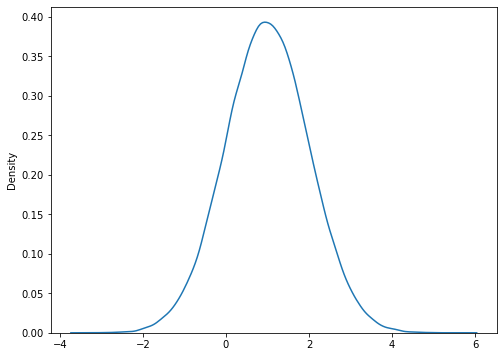

In [ ]:
#проверим как работает
hist_data = np.random.normal(loc = control_mean,
                               scale = control_sd,
                               size = 50000)
print('Средняя по историческим данным', hist_data.mean())
print('Стандартное отклонение по историческим данным', hist_data.std())
sns.kdeplot(hist_data)

(1680, 0.802)

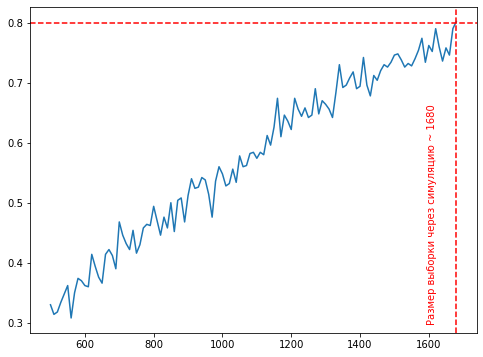

In [ ]:
# найдем по историческим данным  какая нам нужна выборка для детекции нужного MDE на тсиорических данных
find_tt_sample_size(hist_data = hist_data, n_sim = 500, sample_size_start = 500, rel_effect = 0.1, sample_size_step = 10)

сравним с мощностью рассчитанной аналитически

In [ ]:
rel_effect = 0.1         # минимальный аплифт, который ожидает менеджер
control_mean = hist_data.mean()         # среднее в контрольной группе
control_sd = hist_data.std()           # стандартное отклонение в контрольной группе
alpha = 0.05             # уровень значимости

In [ ]:
treat_mean = control_mean*(1 + rel_effect)
mean_diff = treat_mean - control_mean

# Расчет индекса Коэна
cohen_d = mean_diff / control_sd

n = tt_ind_solve_power(effect_size = cohen_d,
                       alpha = 0.05,
                       power = 0.8,
                       ratio = 1,
                       alternative = "two-sided")
print('Минимальный размер выборки для достижения уровня значимости: {:.0f}'.format(round(n)))

Минимальный размер выборки для достижения уровня значимости: 1614


**Ссылки на стат. библиотеку:**

- https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_effectsize.html
- https://www.statsmodels.org/dev/generated/statsmodels.stats.power.TTestPower.plot_power.html


### 3. Влияние на расчет размера выборки, уровня статистической значимости

In [ ]:
# Параметры эксперимента
alpha = 0.05    # установленный уровень значимости = 0.05
power = 0.8    # статистический уровень мощности
rel_mde = 0.1      # минимальный размер эффекта, который хотим задетектить. относительный

# пропорции, если эффект присутствует
p1 = 0.10            # контрольная группа (старый логотип)
p2 = p1 * (1 + rel_MDE)   # тестовая группа (новый логотип)

#### Величина эффекта для пропорций

Jacob Cohen. Statistical Power Analysis for the Behavioral Sciences (стр.182): </br>
https://www.taylorfrancis.com/books/mono/10.4324/9780203771587/statistical-power-analysis-behavioral-sciences-jacob-cohen

Стандартизация величины эффекта для пропорций:</br> https://www.statsmodels.org/dev/_modules/statsmodels/stats/proportion.html#proportion_effectsize

$$
d = 2 * (arcsin({p_1}^{1/2}) - arcsin({p_2}^{1/2}))
$$

In [ ]:
# поработаем с анализом размера выборки для разницы долей (пропорций)
def ztest_power_analysis():
    '''Функция определяет размер выборки в зависимости от выбранной мощности теста и уровня значимости'''

    # стандартизация величины эффекта
    d = sm.stats.proportion_effectsize(p1, p2) # рассчет стандартизированного эффекта для двух разницы двух долей

    # размер выборки для каждой группы
    n = sms.NormalIndPower().solve_power(
                effect_size = d,
                power = power,
                alpha = alpha,
                ratio = 1
                )
    print('Установленный уровень значимости: ', alpha)
    print(f'Размер выборки для каждой группы, необходимый, чтобы задетектить эффект в {100*rel_mde}%: ', n)


    # расчет мощности для z-теста для двух независимых групп
    ztest_power = sms.NormalIndPower()

    sample_sizes = np.arange(50,round(1.5*n),10)

    # построение графика
    (ztest_power.plot_power(dep_var='nobs', nobs=sample_sizes,
    effect_size=[d], alpha = alpha, title=f'Анализ мощности при alpha = {alpha}'))

    # график, показывающий какую мощность теста можно достичь при заданном размере выборки
    plt.axhline(power, linestyle='--', label='выбранная мощность')
    plt.axvline(n, linestyle='--', color='orange', label='требуемая выборка')
    plt.ylabel('Мощность теста')
    plt.xlabel('Размер выборки')
    plt.grid(alpha=0.08)
    plt.legend()
    plt.show()

Установленный уровень значимости:  0.1
Размер выборки для каждой группы, необходимый, чтобы задетектить эффект в 10.0%:  11782.103478440791


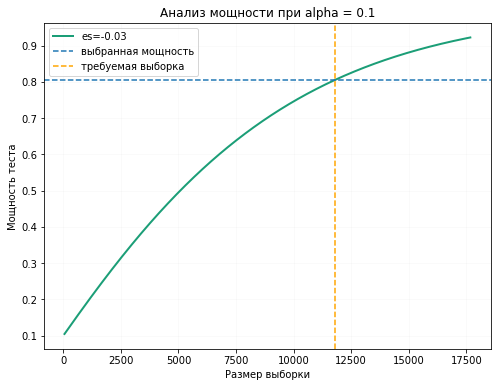

Установленный уровень значимости:  0.05
Размер выборки для каждой группы, необходимый, чтобы задетектить эффект в 10.0%:  14934.135108908427


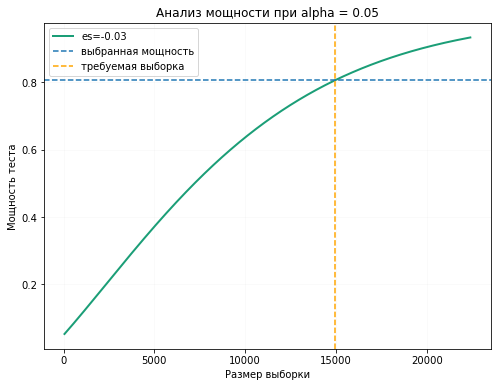

Установленный уровень значимости:  0.01
Размер выборки для каждой группы, необходимый, чтобы задетектить эффект в 10.0%:  22170.639504184845


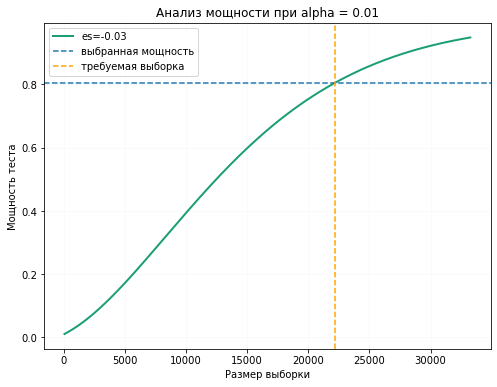

In [ ]:
for alpha in [0.1, 0.05, 0.01]:
    ztest_power_analysis()

### 4. Влияние величины эффекта на размер выборки для требуемой мощности

In [ ]:
p1 = [0.1, 0.08, 0.05]
p2 = [0.11, 0.0864, 0.0525]

d = sm.stats.proportion_effectsize(p1, p2)
effect_sizes = array(d)

n = round(tt_ind_solve_power(effect_size=max(effect_sizes), power=power, alpha=alpha))
sample_sizes = array(range(5, n+1000))

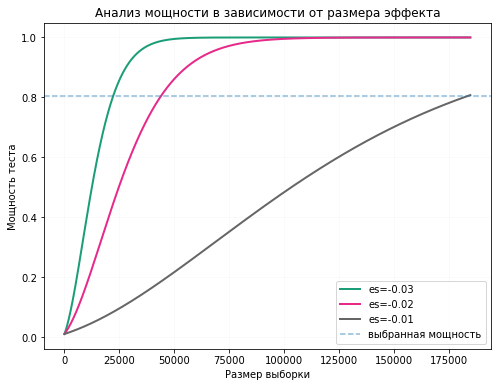

In [ ]:
ztest_power.plot_power(
     dep_var='nobs', nobs=sample_sizes,
     effect_size=effect_sizes, alpha = alpha, title='Анализ мощности в зависимости от размера эффекта')

# график, показывающий размер выборки для различных эффектов и заданной мощности
plt.axhline(power, linestyle='--', label='выбранная мощность', alpha=0.5)
plt.ylabel('Мощность теста')
plt.xlabel('Размер выборки')
plt.grid(alpha=0.08)
plt.legend()
plt.show()

Источник: Dennis Meisner. Finding the right significance level for an AB-test: https://towardsdatascience.com/finding-the-right-significance-level-for-an-ab-test-26d907ca91c9